<a href="https://colab.research.google.com/github/EnterTheBeginning/Machine-Learning/blob/master/HW3_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-Tuning

Now there is a need to Unfreeze some layers in Conv Base network. 

Then Jointly train both layers and the parts that are added

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import os
import zipfile

from keras.layers import Dense,Dropout,Activation,Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras import optimizers


##Preprocessing

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join()
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
conv_base = VGG19(weights='imagenet',include_top=False,input_shape=(150,150,3))

--2019-04-16 18:45:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  58.8MB/s    in 1.1s    

2019-04-16 18:45:50 (58.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Instructions for updating:
Colocations handled automatically by placer.


##Freezing the Conv Base

In [0]:
conv_base.trainable = False
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

##Unfreezing

In [9]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Lets fine tune the last **four CNN** layers = all layers above needs to be frozen

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [19]:
#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)
test_generator = 


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps = 50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 29s 286ms/step - loss: 0.4853 - acc: 0.7530 - val_loss: 0.3979 - val_acc: 0.8190
Epoch 2/30
100/100 [==============================] - 22s 223ms/step - loss: 0.3283 - acc: 0.8550 - val_loss: 0.3706 - val_acc: 0.8420
Epoch 3/30
100/100 [==============================] - 23s 229ms/step - loss: 0.2963 - acc: 0.8735 - val_loss: 0.3003 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 23s 232ms/step - loss: 0.2577 - acc: 0.8975 - val_loss: 0.2883 - val_acc: 0.8680
Epoch 5/30
100/100 [==============================] - 22s 222ms/step - loss: 0.2275 - acc: 0.9075 - val_loss: 0.2604 - val_acc: 0.9000
Epoch 6/30
100/100 [==============================] - 22s 223ms/step - loss: 0.2175 - acc: 0.9175 - val_loss: 0.3180 - val_acc: 0.8730
Epoch 7/30
100/100 [==============================] - 23s 229ms/step - loss: 0.2122 - acc: 0.9050 - val_loss: 0.2176 - val_acc: 0.9120
Epoch 8

In [23]:
score= model.evaluate_generator(validation_generator,steps = 50)
print("Loss :",score[0])
print("Accuracy: ",score[1])


Loss : 0.3058997538080439
Accuracy:  0.9209999930858612


Accuracy of 92% initially.

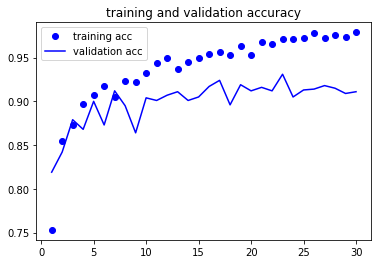

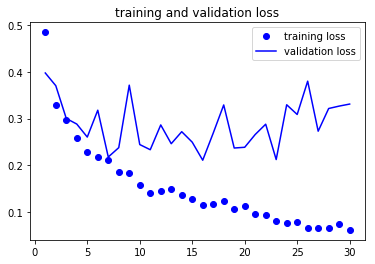

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()
